# Multiclass Image Classification - Deep Learning Final Project
### Calista Lianardi - 2702325880
### Ririn Saprina Kadang - 27023157151

In [4]:
#Importing Library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

# deep learning libraries
import tensorflow as tf
import keras
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0

import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [154]:
from pathlib import Path
import imghdr

data_dir = "C:/Users/liana/Downloads/Final Project DL - Multiclass Image Classification/ClassifiedDataset"
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Land_Slide\04_01_0007.png is a webp, not accepted by TensorFlow
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0031.png is not an image
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0033.png is not an image
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0060.png is a webp, not accepted by TensorFlow
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0088.png is not an image
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0189.png is not an image
C:\Users\liana\Downloads\Final Project DL - Multiclass Image Classification\ClassifiedDataset\Urban_Fire\01_01_0281.png is not an image
C:\U

In [8]:
path = "C:/Users/liana/Downloads/Final Project DL - Multiclass Image Classification/ClassifiedDataset"
classes = ['Earthquake', 'Urban_Fire', 'Land_Slide', 'Water_Disaster']


In [158]:
def remove_invalid_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()  # Verify that it is an image
            except (IOError, SyntaxError) as e:
                print(f"Removing invalid image: {path}")
                os.remove(path)

# Call the function with your dataset directory
remove_invalid_images('C:/Users/liana/Downloads/Final Project DL - Multiclass Image Classification/ClassifiedDataset/tts')

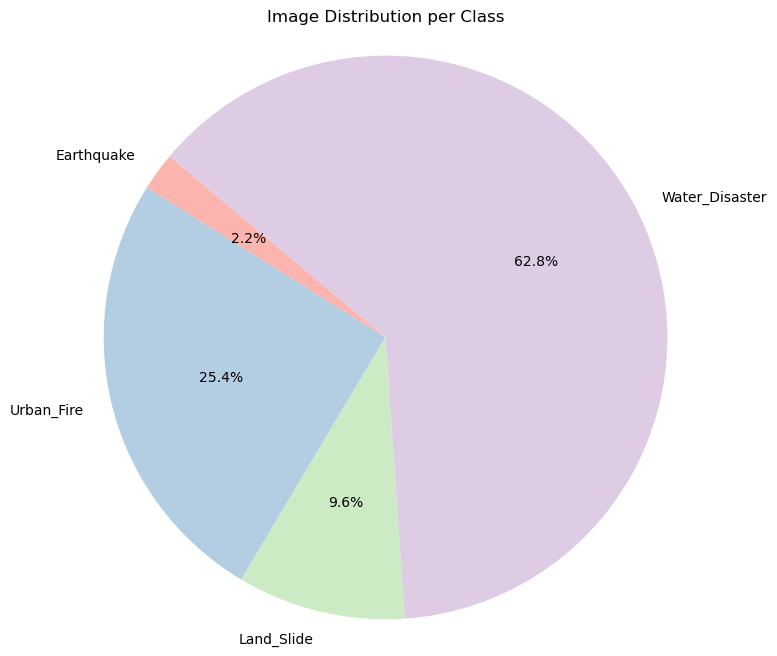

In [160]:
class_counts = {}
for cls in classes:
    cls_path = os.path.join(path, cls)
    num_images = len(os.listdir(cls_path))
    class_counts[cls] = num_images

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Image Distribution per Class")
plt.axis('equal')  # Makes the pie chart a circle
plt.show()

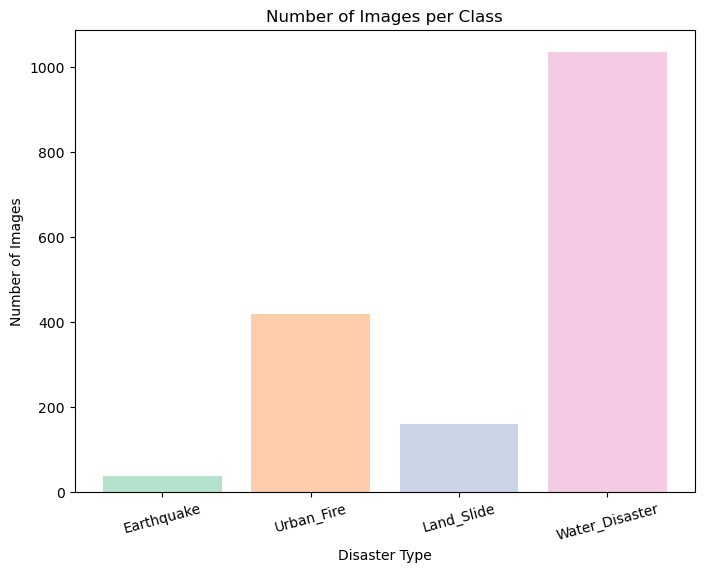

In [162]:
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=plt.cm.Pastel2.colors)
plt.title("Number of Images per Class")
plt.xlabel("Disaster Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()


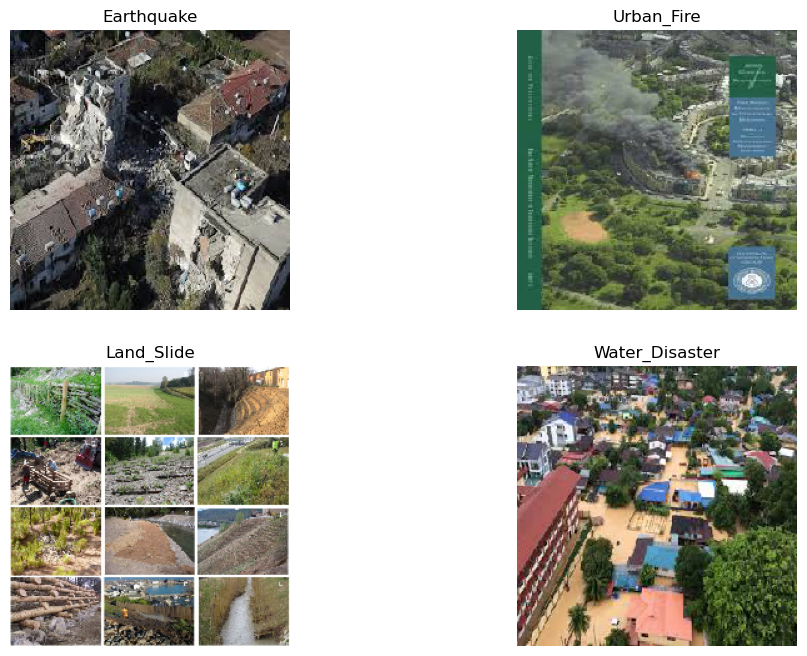

In [164]:
plt.figure(figsize=(12, 8))

for i, classes in enumerate(classes):
    img_path = os.path.join(path, classes)
    img_file = os.listdir(img_path)[0]  # take first image
    
    img = tf.keras.preprocessing.image.load_img(os.path.join(img_path, img_file), target_size=(224, 224))
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(classes)
    plt.axis('off')

plt.show()


In [165]:
from PIL import Image

classes = ['Earthquake', 'Urban_Fire', 'Land_Slide', 'Water_Disaster']
widths, heights = [], []

for class_name in classes:
    img_dir = os.path.join(path, class_name )
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        with Image.open(img_path) as img:
            widths.append(img.width)
            heights.append(img.height)
            img.verify()

print(f'Average width: {sum(widths)/len(widths):.1f}')
print(f'Average height: {sum(heights)/len(heights):.1f}')
print(f'Min width: {min(widths)}, Max width: {max(widths)}')
print(f'Min height: {min(heights)}, Max height: {max(heights)}')


Average width: 495.0
Average height: 425.5
Min width: 161, Max width: 1280
Min height: 120, Max height: 1350


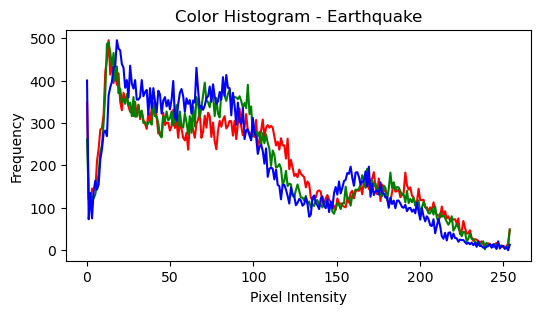

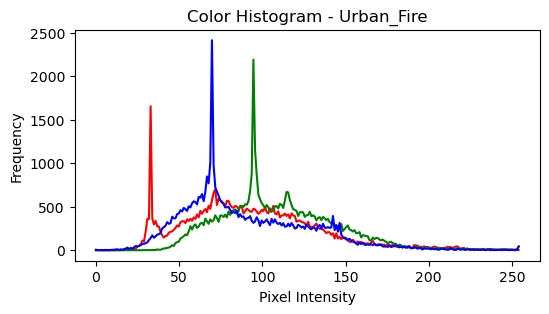

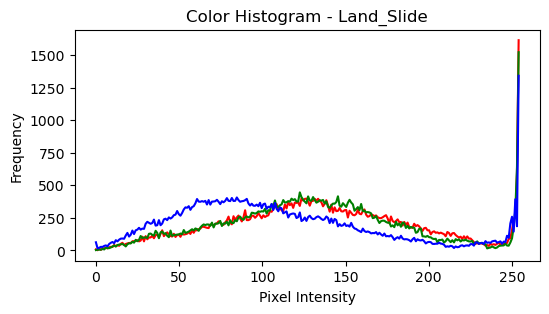

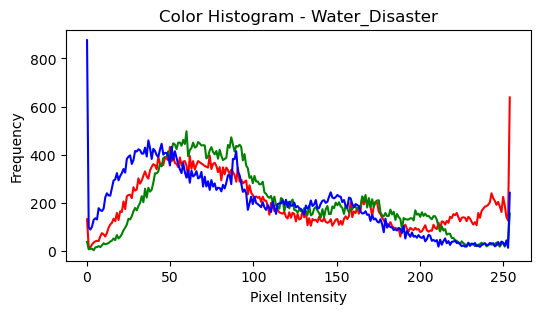

In [167]:
import numpy as np

# Pick one sample image per class (use the code from previous step)
# For simplicity, reuse sample image loaded above

for class_name in classes:
    img_path = os.path.join(path, class_name, os.listdir(os.path.join(path, class_name))[0])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_arr = np.array(img)

    plt.figure(figsize=(6, 3))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist, bins = np.histogram(img_arr[:, :, i], bins=256, range=(0, 255))
        plt.plot(bins[:-1], hist, color=color)
    plt.title(f'Color Histogram - {class_name}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [169]:
import cv2

means = {c: [] for c in classes}
stds = {c: [] for c in classes}

for class_name in classes:
    img_dir = os.path.join(path, class_name)
    for img_file in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)  # BGR format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        means[class_name].append(np.mean(img, axis=(0,1)))
        stds[class_name].append(np.std(img, axis=(0,1)))

for c in classes:
    mean = np.mean(means[c], axis=0)
    std = np.mean(stds[c], axis=0)
    print(f'{c}: Mean RGB = {mean}, Std RGB = {std}')


Earthquake: Mean RGB = [104.36645006 101.51527037  97.62516324], Std RGB = [54.65995963 53.24539919 52.93284134]
Urban_Fire: Mean RGB = [115.73216874  95.35117087  83.3369616 ], Std RGB = [62.24745199 54.68438467 49.60209463]
Land_Slide: Mean RGB = [114.82724105 111.81437547 103.03791906], Std RGB = [55.49910042 53.38805783 55.07883997]
Water_Disaster: Mean RGB = [126.19792234 125.80730789 118.32550659], Std RGB = [54.27327803 52.28182707 55.53130512]


In [171]:
size_counts = {}
wrong_shapes = []

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            size = img.size  # (width, height)
            size_counts[size] = size_counts.get(size, 0) + 1
            if img.mode != 'RGB':
                wrong_shapes.append((img_file, img.mode, size))

# Print counts sorted by most common sizes
for size, count in sorted(size_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{size}: {count}")


(275, 183): 188
(300, 168): 161
(259, 194): 83
(1080, 1080): 81
(640, 640): 72
(768, 768): 56
(299, 168): 53
(720, 720): 49
(600, 600): 36
(500, 500): 34
(608, 608): 27
(612, 612): 27
(800, 800): 25
(400, 400): 24
(276, 183): 23
(284, 177): 18
(700, 700): 17
(620, 620): 15
(290, 174): 14
(310, 163): 13
(277, 182): 12
(1080, 810): 12
(540, 540): 11
(260, 194): 10
(480, 480): 10
(278, 181): 9
(262, 192): 9
(268, 188): 9
(274, 184): 8
(360, 360): 8
(273, 185): 8
(1080, 720): 8
(1080, 1350): 8
(302, 167): 7
(318, 159): 7
(286, 176): 7
(1080, 809): 7
(285, 177): 7
(720, 405): 7
(308, 164): 6
(225, 225): 6
(280, 180): 6
(750, 750): 6
(194, 259): 6
(460, 460): 6
(450, 450): 6
(291, 173): 5
(512, 512): 5
(264, 191): 5
(415, 415): 5
(960, 960): 5
(265, 190): 5
(269, 187): 4
(289, 174): 4
(282, 179): 4
(263, 192): 4
(295, 171): 4
(615, 615): 4
(590, 590): 4
(279, 181): 4
(283, 178): 4
(1080, 607): 4
(1080, 718): 4
(288, 175): 4
(299, 169): 4
(336, 150): 4
(276, 182): 4
(612, 765): 4
(306, 165): 

#### **Train test val split for the dataset**

In [173]:
# Train Test Val Split for the dataset

output_path = "tts"

# Create the folder structure
for j in ['train', 'val', 'test']:
    for i in classes:
        os.makedirs(os.path.join(output_path, j, i), exist_ok=True)

In [174]:
for i in classes:
    source_folder = os.path.join(path, i)
    images = [img for img in os.listdir(source_folder) if img.lower().endswith(('.png'))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Copy images
    for img in train_imgs:
        shutil.copy(os.path.join(source_folder, img), os.path.join(output_path, 'train', i, img))
    for img in val_imgs:
        shutil.copy(os.path.join(source_folder, img), os.path.join(output_path, 'val', i, img))
    for img in test_imgs:
        shutil.copy(os.path.join(source_folder, img), os.path.join(output_path, 'test', i, img))

In [175]:
img_sze = (224, 224)
batch = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_path, 'train'),
    image_size=img_sze,
    batch_size=batch,
    label_mode='int'  
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_path, 'val'),
    image_size=img_sze,
    batch_size=batch,
    label_mode='int'  
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(output_path, 'test'),
    image_size=img_sze,
    batch_size=batch,
    label_mode='int'  
)

Found 1152 files belonging to 4 classes.
Found 247 files belonging to 4 classes.
Found 249 files belonging to 4 classes.


In [176]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = ['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster']
image_counts = [36, 160, 419, 1035]

# Convert to labels
labels = []
for i, count in enumerate(image_counts):
    labels += [i] * count

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

print(class_weights)


{0: 11.458333333333334, 1: 2.578125, 2: 0.9844868735083532, 3: 0.39855072463768115}


### Model 1: Scratch Build Model

In [10]:
classes = 4
input_shape = (224, 224, 3)

CLRKModel = models.Sequential([
    #input
    layers.Input(input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    #Layer penyet and dense
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    #output
    layers.Dense(classes, activation='softmax')  # Output Layer
])

CLRKModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,532 (431.77 KB)

 Trainable params: 110,404 (431.27 KB)

 Non-trainable params: 128 (512.00 B)

In [246]:
# Compile and Training Our Model 

CLRKModel.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

NewModel = CLRKModel.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 10,
    batch_size = 32,
    class_weight=class_weights
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 375s 9s/step - accuracy: 0.4438 - loss: 1.2481 - val_accuracy: 0.6640 - val_loss: 1.6708
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 278s 6s/step - accuracy: 0.5254 - loss: 1.0743 - val_accuracy: 0.1538 - val_loss: 2.5428
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 214s 5s/step - accuracy: 0.5421 - loss: 0.9949 - val_accuracy: 0.5142 - val_loss: 1.0574
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.5458 - loss: 0.8874 - val_accuracy: 0.7409 - val_loss: 0.7579
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.5565 - loss: 0.9424 - val_accuracy: 0.1296 - val_loss: 4.2400
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.5617 - loss: 0.8863 - val_accuracy: 0.3725 - val_loss: 1.5018
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step - accuracy: 0.6242 - loss: 0.8669 - val_accuracy: 0.6640 - val_loss: 0.9644
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.5698 - loss: 0.9600 - val_accuracy: 0.1943 - v

### Model 2: EfficientNetB0

In [12]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(classes, activation='softmax')  
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,219,175 (16.09 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [14]:
# Compile and Train Model

model2.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

efficientb0 = model2.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 10,
    batch_size = 32,
    class_weight=class_weights
)

NameError: name 'train_ds' is not defined

### **Evaluating The Model**

#### Model 1: CLRKModel

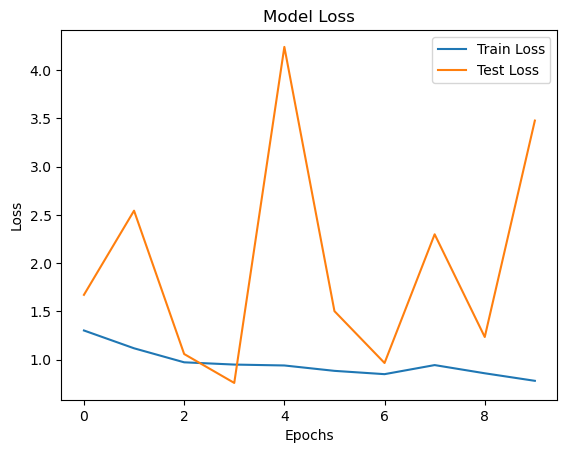

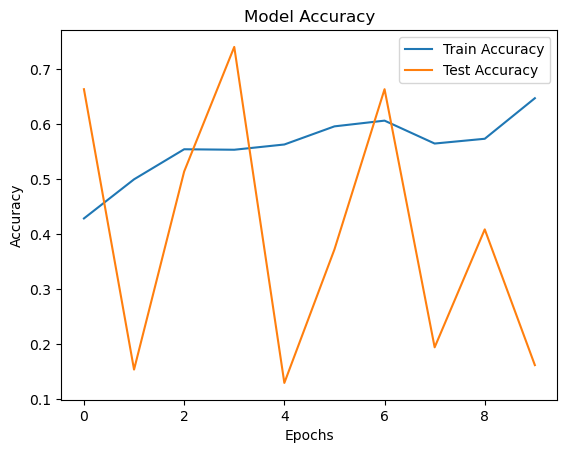

In [247]:
# Loss
plt.plot(NewModel.history['loss'])
plt.plot(NewModel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

# Training and Vaidation Accuracy
plt.plot(NewModel.history['accuracy'])
plt.plot(NewModel.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 972ms/step
              precision    recall  f1-score   support

           0       0.02      0.60      0.03         5
           1       0.00      0.00      0.00        24
           2       0.35      0.30      0.32        63
           3       0.00      0.00      0.00       155

    accuracy                           0.09       247
   macro avg       0.09      0.23      0.09       247
weighted avg       0.09      0.09      0.08       247



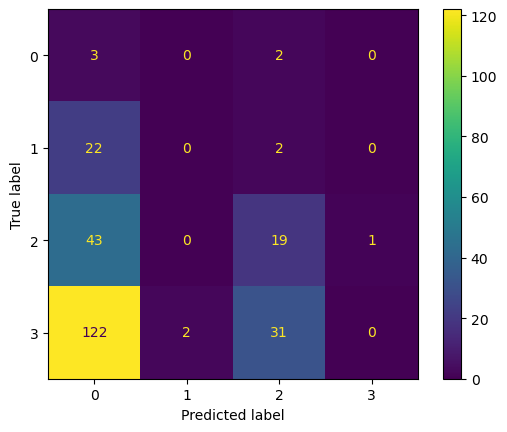

In [248]:
#Confusion Matrix 

y_pred = CLRKModel.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_true, y_pred_classes))

#### Model 2: EfficientNet-B0

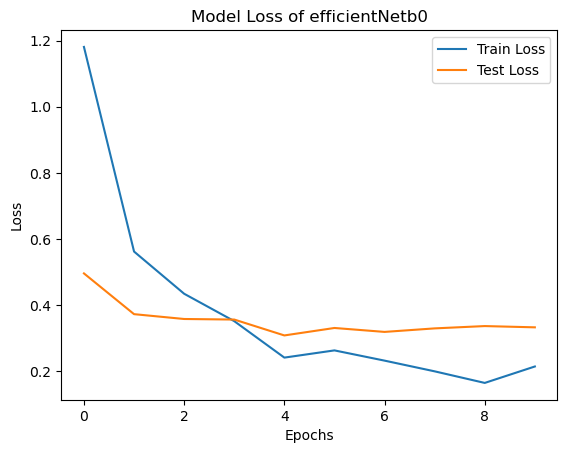

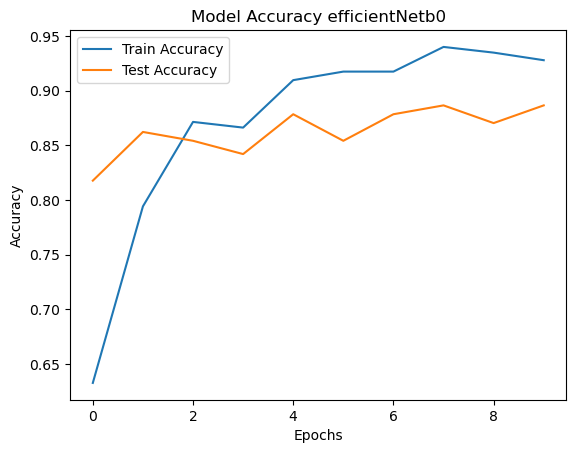

In [230]:
# Loss
plt.plot(efficientb0.history['loss'])
plt.plot(efficientb0.history['val_loss'])
plt.title('Model Loss of efficientNetb0')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

# Training and Vaidation Accuracy
plt.plot(efficientb0.history['accuracy'])
plt.plot(efficientb0.history['val_accuracy'])
plt.title('Model Accuracy efficientNetb0')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.06      0.08      0.07        24
           2       0.35      0.32      0.33        63
           3       0.65      0.63      0.64       155

    accuracy                           0.48       247
   macro avg       0.26      0.26      0.26       247
weighted avg       0.50      0.48      0.49       247



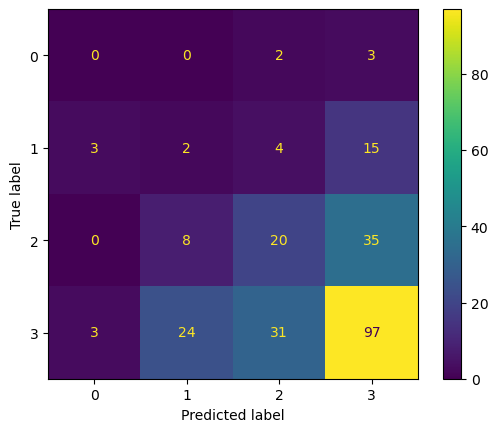

In [227]:
#Confusion Matrix 

y_pred = model2.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_true, y_pred_classes))

#### Refined Version of CLRKModel: CLRKModelV2

In [16]:
# Me refine model sndiri

CLRKModelv2 = models.Sequential([
    #input
    layers.Input(input_shape),

    #mengurangi convolution layer untuk mencegah overfitting, mengingat dtaset earthquake sangat kecil (<100)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    #Layer penyet and dense
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(64, activation='relu'), #mengurangi dense layer agar sesuai dengan conv layer 2
    layers.Dropout(0.3), #mengurangi dropout rate dari modeling yang pertama

    #output
    layers.Dense(classes, activation='softmax')  # Output Layer
])

CLRKModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,532 (431.77 KB)

 Trainable params: 110,404 (431.27 KB)

 Non-trainable params: 128 (512.00 B)

In [256]:
# Compile and Training Model Sendiri V2

CLRKModelv2.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

NewModelv2 = CLRKModel.fit(
    train_ds, 
    validation_data = val_ds,
    epochs = 10,
    batch_size = 32,
    class_weight=class_weights
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 200s 5s/step - accuracy: 0.6499 - loss: 0.7953 - val_accuracy: 0.3644 - val_loss: 1.7993
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 256s 7s/step - accuracy: 0.6371 - loss: 0.8273 - val_accuracy: 0.6761 - val_loss: 0.8301
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.6805 - loss: 0.7454 - val_accuracy: 0.4615 - val_loss: 1.2174
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 6s/step - accuracy: 0.6630 - loss: 0.7164 - val_accuracy: 0.1619 - val_loss: 2.8163
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - accuracy: 0.6616 - loss: 0.7130 - val_accuracy: 0.7490 - val_loss: 0.6417
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 226s 6s/step - accuracy: 0.6805 - loss: 0.7094 - val_accuracy: 0.7247 - val_loss: 0.8553
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 275s 7s/step - accuracy: 0.6743 - loss: 0.7208 - val_accuracy: 0.7571 - val_loss: 0.6904
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 229s 6s/step - accuracy: 0.6798 - loss: 0.6844 - val_accuracy: 0.4818 - v

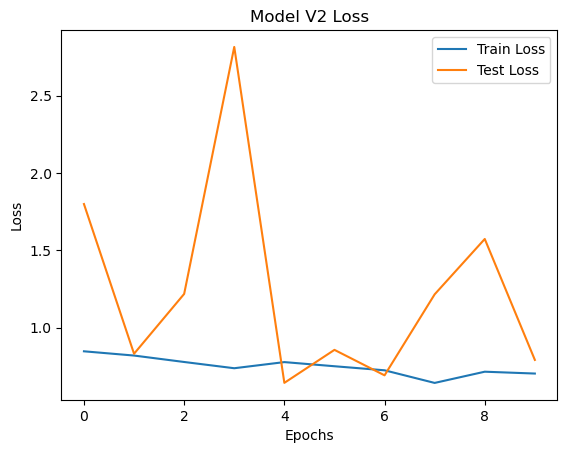

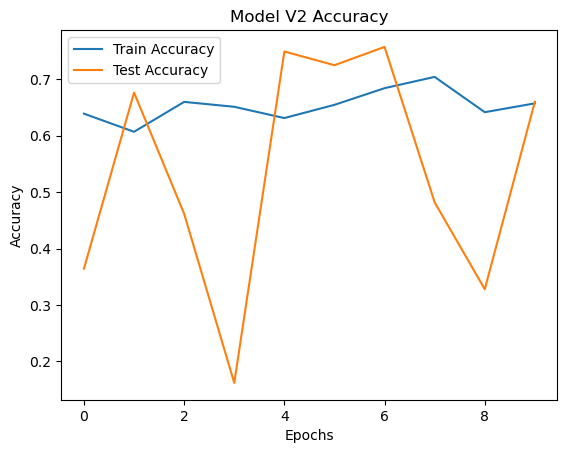

In [257]:
# Loss
plt.plot(NewModelv2.history['loss'])
plt.plot(NewModelv2.history['val_loss'])
plt.title('Model V2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

# Training and Vaidation Accuracy
plt.plot(NewModelv2.history['accuracy'])
plt.plot(NewModelv2.history['val_accuracy'])
plt.title('Model V2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        24
           2       0.26      1.00      0.41        63
           3       0.00      0.00      0.00       155

    accuracy                           0.26       247
   macro avg       0.06      0.25      0.10       247
weighted avg       0.07      0.26      0.10       247



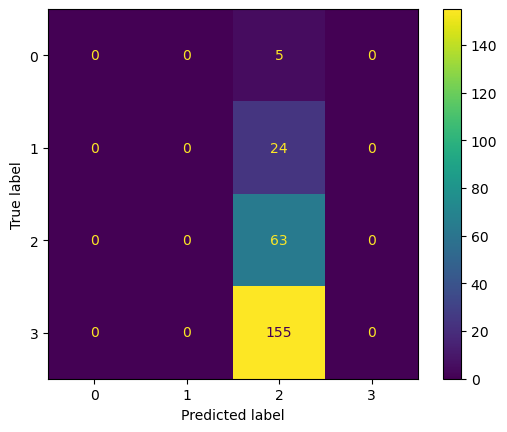

In [258]:
#Confusion Matrix 

y_pred = CLRKModelv2.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_true, y_pred_classes))